# Visualization of Cloud-Optimized Earth Observation Data using Lonboard

This tutorial illustrates processing and visualizing EO data - Cloud-Optimized GeoTIFFs (COGs) and Cloud-Optimized Point Clouds (COPCs) using [Lonboard](https://developmentseed.org/lonboard/latest/). Lonboard is capable of visualizing big raster and vector datasets including widely used image formats such as COGs and LiDAR data files such as COPCs, LAS file formats.

In this tutorial, Airborne LiDAR Scanning (ALS) based point cloud for Panama, BCI is used for visualization along with the Above-ground Biomass (AGB) Estimate COG and [Meta's Canopy Height Model (CHM) COG products. For COG visualization, we use [TiTiler](https://developmentseed.org/titiler/) for dynamically serving tiles from the generated COGs. The point cloud represents normalized canopy cover heights generated from the raw point cloud data.

Additional Resources:
1. [Lonboard](https://developmentseed.org/lonboard/latest/)
2. [TiTiler](https://developmentseed.org/titiler/)
3. [Converting LiDAR LAS Files to Cloud-Optimized Point Clouds (COPCs)](https://guide.cloudnativegeo.org/copc/lidar-las-to-copc.html)
4. [Introduction to Cloud-Optimized GeoTIFFs](https://guide.cloudnativegeo.org/cloud-optimized-geotiffs/intro.html)
5. [PDAL](https://pdal.io/en/2.6.0/about.html#what-is-pdal)


### Importing Packages

We import the required packages for this tutorial.  

In [99]:
import geopandas as gpd
from lonboard import viz
import pdal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lonboard import Map, BitmapLayer, BitmapTileLayer, PointCloudLayer
from lonboard.colormap import apply_continuous_cmap
import httpx
import json
from palettable.colorbrewer.sequential import YlGnBu_7, Greens_3
from palettable.colorbrewer.diverging import Spectral_9
from matplotlib.colors import Normalize

Next, we define the path to the ALS LiDAR file in COPC format to be visualized.

In [2]:
out_file = "data/ALS_ground_copc/outputs/norm_copc/norm_copc_chunk_624600_1013000.copc.laz"

### Reading the COPC file

We read the COPC file using the PDAL python package. Also, we sample the number of points by a factor of 10, thus reducing the number of points for visualization to save memory. PDAL processes point cloud data by executing pipelines comprising of various operations (separated by `|` below). For more details, the readers are recommended to follow [Converting LiDAR LAS Files to Cloud-Optimized Point Clouds (COPCs)](https://guide.cloudnativegeo.org/copc/lidar-las-to-copc.html).

In [3]:
pipeline = (pdal.Reader.copc(filename=out_file) | pdal.Filter.decimation(step=10) | pdal.Filter.stats())
pipeline.execute()

895968

### Getting the Data Values

The data values from an executed pipeline are retrieved by calling the `arrays` method.

In [4]:
# Getting array values
arr_values = pipeline.arrays

### Creating Geo-dataframe

Now, we will create a data frame followed by a Geo-dataframe based on the data values. Lonboard requires the vector data as Geo-dataframe for visualization.

In [5]:
df = pd.DataFrame(arr_values[0])

In [6]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y, z=df.Z), crs="32617")

Also, Lonboard requires the Geo-dataframe to have its Spatial Reference System (SRS) as World Geodetic System 1984 (WGS 84). So, we re-project the geo-dataframe to `EPSG 4326`, which is the unique reference code for WGS 84.

In [7]:
gdf_proj = gdf.to_crs(4326)
gdf_proj.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,ScanChannel,ClassFlags,TargetThick,DevRatio,Zref,geometry
0,624774.88,1013175.93,15.55,43,1,3,0,0,1,-29.742001,1,13,3.691527e+08,0,0,0.184,0.9,43.19,POINT Z (-79.86435 9.16396 15.55000)
1,624773.58,1013178.64,14.74,22,3,5,0,0,1,-29.658001,27,13,3.691527e+08,0,0,0.144,1.2,43.39,POINT Z (-79.86436 9.16398 14.74000)
2,624774.83,1013196.42,17.34,14,3,3,0,0,1,-28.865999,1,13,3.691527e+08,0,0,0.216,1.1,50.77,POINT Z (-79.86435 9.16414 17.34000)
3,624765.98,1013175.28,16.76,59,1,1,0,0,1,-30.167999,1,13,3.691527e+08,0,0,0.152,1.5,44.22,POINT Z (-79.86443 9.16395 16.76000)
4,624774.43,1013196.64,-0.01,55,3,3,0,0,2,-28.242001,1,13,3.691527e+08,0,0,0.088,0.9,33.52,POINT Z (-79.86435 9.16415 -0.01000)


In order to save memory, we delete the unrequired data frames. Also, we drop the columns which are not relevant for the visulization.

In [8]:
# Deleting not required dataframes
del(df)
del(gdf)

In [9]:
#Dropping not required columns
gdf_proj = gdf_proj.drop(['ReturnNumber', 'NumberOfReturns', 'ScanDirectionFlag', 'EdgeOfFlightLine', 'ScanAngleRank', 'UserData', 'PointSourceId', 'GpsTime', 'Intensity', 'Classification', 'ScanChannel', 'ClassFlags', 'TargetThick', 'DevRatio', 'Zref'], axis=1)

### Define a Point Cloud Layer

We define a Point Cloud Layer based on the geo-dataframe.

In [10]:
point_layer = PointCloudLayer.from_geopandas(gdf_proj, point_size=2)

### Styling Point Cloud Layer

Here, we normalize the elevation values and create a color map for visualizing the point cloud layer. 

In [11]:
normalizer = Normalize(1, gdf_proj["Z"].max(), clip=True)
normalized_heights = normalizer(gdf_proj["Z"])

In [12]:
point_layer.get_color = apply_continuous_cmap(normalized_heights, Greens_3, alpha=0.6)

### Reading AGB Product Layer

For visualizing COGs, we use `BitmapTileLayer` which renders tiles dynamically generated by TiTiler.

In [13]:
titiler_endpoint = "https://titiler.maap-project.org"

In [14]:
#AGB product stored locally in MAAP workspace
agb_product_url = "s3://maap-ops-workspace/shared/omshinde23/agbd.tif"

In [15]:
agb_product_tile_url = "https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-workspace/shared/omshinde23/agbd.tif&bidx=5&rescale=0,600&colormap_name=viridis"

In [16]:
r_agb = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": agb_product_url,
    }
).json()

bounds_agb = r_agb["bounds"]
print(bounds_agb)

[-79.87926821173158, 9.121956517182756, -79.81171917965493, 9.186829702218509]


In [17]:
agb_product_layer = BitmapTileLayer(
    data=agb_product_tile_url,
    tile_size=148,
    max_requests=-1,
    min_zoom=3,
    max_zoom=18,
    extent=bounds_agb
)

### Creating Map Visualization for AGB Layer

Here, we visualize the AGB layer and point cloud layer in a single `Map` widget. The readers are recommended to use `Ctrl+Click+Drag` to change the viewing angle. 

In [95]:
#Function for generating colormap for AGB and CHM layer legend

def plot_colormap(title, cmap):
    
    gradient = np.linspace(0, 1, 60)
    gradient = np.vstack((gradient, gradient))
    
    # Create figure and adjust figure height to number of colormaps
    nrows = 1
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)
    
    axs.get_yaxis().set_visible(False)

    axs.set_title(title, fontsize=14)
    axs.imshow(gradient, aspect='auto', cmap=cmap)

In [98]:
m = Map([agb_product_layer, point_layer])
m

Map(layers=[BitmapTileLayer(data='https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-wor…

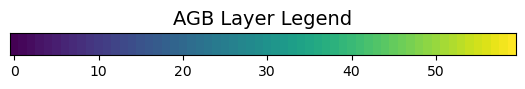

In [97]:
plot_colormap("AGB Layer Legend",'viridis')

### Reading META CHM Layer

Now, we visualize the META CHM layer with the point cloud layer.

In [24]:
chm_product_url = "s3://maap-ops-workspace/shared/omshinde23/meta_chm_new.tif"

In [25]:
chm_product_tile_url = "https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-workspace/shared/omshinde23/meta_chm_new.tif&rescale=0,60&colormap_name=viridis"

In [26]:
r_chm = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": chm_product_url,
    }
).json()

bounds_chm = r_chm["bounds"]
print(bounds_chm)

[-79.87929430332252, 9.122007215999078, -79.81190140986412, 9.187029513446365]


In [27]:
chm_product_layer = BitmapTileLayer(
    data=chm_product_tile_url,
    tile_size=148,
    max_requests=-1,
    min_zoom=3,
    max_zoom=18,
    extent=bounds_chm
)

In [53]:
m1 = Map([chm_product_layer, point_layer])
m1

Map(layers=[BitmapTileLayer(data='https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-wor…

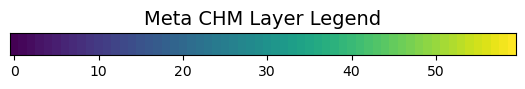

In [96]:
plot_colormap("Meta CHM Layer Legend",'viridis')